Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import time

from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from pyrcn.echo_state_network import ESNRegressor
import matplotlib
from matplotlib import pyplot as plt
#Options
params = {'image.cmap' : 'RdBu',
          'text.usetex' : True,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import librosa

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Print number of files that are included in the dataset

In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


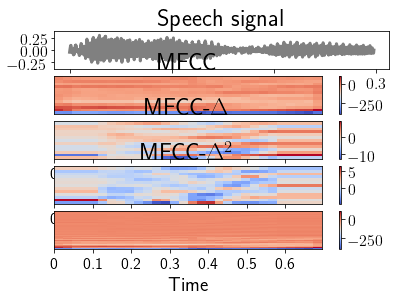

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(np.vstack((mfcc, mfcc_delta, mfcc_delta2)), x_axis='time')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [4]:
X = [None] * len(all_files)
y = [None] * len(all_files)
print("extracting features...")
with tqdm(total=len(all_files)) as pbar:
    for k, f in enumerate(all_files):
        basename = os.path.basename(f).split('.')[0]
        # Get label (0-9) of recording.
        label = int(basename.split('_')[0])
        # Load the audio signal and normalize it.
        x, sr = librosa.core.load(f, sr=None, mono=False)
        # x /= np.max(np.abs(x))
        mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        X[k] = mfcc.T
        y[k] = label
        pbar.update(1)
print("done!")

extracting features...


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 368.82it/s]


done!


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

Validate training and test sizes

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_val), len(y_val), X_val[0].shape, y_val[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2400 2400 (40, 13) 5
300 300 (54, 13) 9
300 300 (41, 13) 3


Normalize all features using the StandardScaler from scikit-learn.

In [7]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = [scaler.transform(X) for X in X_train]
X_val_scaled = [scaler.transform(X) for X in X_val]
X_test_scaled = [scaler.transform(X) for X in X_test]

Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


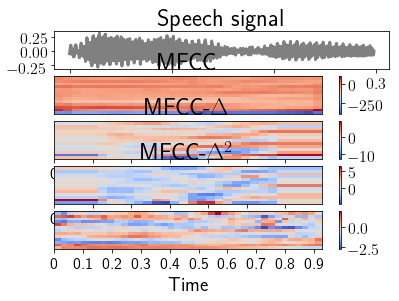

In [8]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(X_train_scaled[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

One-Hot encoding of labels

In [9]:
enc = OneHotEncoder(sparse=False).fit(X=np.asarray(y_train).reshape(-1, 1))

K-Means Clustering

In [10]:
kmeans = MiniBatchKMeans(n_clusters=500, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=1, random_state=0)
kmeans.fit(X=np.vstack(X_train_scaled))

Init 1/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 327.224175
Init 2/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 274.447121
Init 3/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 331.283465
Minibatch iteration 1/106900: mean batch inertia: 3.725833, ewa inertia: 3.725833 
Minibatch iteration 2/106900: mean batch inertia: 3.881756, ewa inertia: 3.726124 
Minibatch iteration 3/106900: mean batch inertia: 3.681032, ewa inertia: 3.726040 
Minibatch iteration 4/106900: mean batch inertia: 3.379444, ewa inertia: 3.725391 
Minibatch iteration 5/106900: mean batch inertia: 3.633030, ewa inertia: 3.725219 
Minibatch iteration 6/106900: mean batch inertia: 3.638565, ewa inertia: 3.725056 
Minibatch iteration 7/106900: mean batch inertia: 3.933620, ewa inertia: 3.725447 
Minibatch iteration 8/106900: mean batch inertia: 3.492223, ewa inertia: 3.725010 
Minibatch iteration 9/106900: mean batch inertia: 4.036831, ewa inertia: 3.725594 
Minibatch iteration 10/106900: mean batch inertia: 3.679328, ewa inertia: 3.725507 
Minibatch iteration 11/106900: mean batch inertia: 3.261993, ewa inertia: 3.724640 
Minibatch iteration 12/106900: mean batch inertia: 3

Minibatch iteration 194/106900: mean batch inertia: 2.950571, ewa inertia: 3.530287 
Minibatch iteration 195/106900: mean batch inertia: 2.732824, ewa inertia: 3.528794 
Minibatch iteration 196/106900: mean batch inertia: 2.972628, ewa inertia: 3.527753 
Minibatch iteration 197/106900: mean batch inertia: 3.021305, ewa inertia: 3.526805 
Minibatch iteration 198/106900: mean batch inertia: 2.727923, ewa inertia: 3.525310 
Minibatch iteration 199/106900: mean batch inertia: 3.056546, ewa inertia: 3.524433 
Minibatch iteration 200/106900: mean batch inertia: 2.670399, ewa inertia: 3.522835 
Minibatch iteration 201/106900: mean batch inertia: 2.933316, ewa inertia: 3.521731 
Minibatch iteration 202/106900: mean batch inertia: 3.081998, ewa inertia: 3.520908 
Minibatch iteration 203/106900: mean batch inertia: 2.777354, ewa inertia: 3.519517 
Minibatch iteration 204/106900: mean batch inertia: 3.041628, ewa inertia: 3.518622 
Minibatch iteration 205/106900: mean batch inertia: 2.973128, ewa

Minibatch iteration 386/106900: mean batch inertia: 2.970527, ewa inertia: 3.327961 
Minibatch iteration 387/106900: mean batch inertia: 2.736049, ewa inertia: 3.326853 
Minibatch iteration 388/106900: mean batch inertia: 2.990517, ewa inertia: 3.326224 
Minibatch iteration 389/106900: mean batch inertia: 2.959426, ewa inertia: 3.325537 
Minibatch iteration 390/106900: mean batch inertia: 2.836729, ewa inertia: 3.324622 
Minibatch iteration 391/106900: mean batch inertia: 3.079814, ewa inertia: 3.324164 
Minibatch iteration 392/106900: mean batch inertia: 2.888024, ewa inertia: 3.323348 
Minibatch iteration 393/106900: mean batch inertia: 2.811433, ewa inertia: 3.322390 
Minibatch iteration 394/106900: mean batch inertia: 2.628892, ewa inertia: 3.321092 
Minibatch iteration 395/106900: mean batch inertia: 2.663553, ewa inertia: 3.319861 
Minibatch iteration 396/106900: mean batch inertia: 2.711915, ewa inertia: 3.318724 
Minibatch iteration 397/106900: mean batch inertia: 2.959427, ewa

Minibatch iteration 578/106900: mean batch inertia: 2.835917, ewa inertia: 3.177061 
Minibatch iteration 579/106900: mean batch inertia: 2.694069, ewa inertia: 3.176157 
Minibatch iteration 580/106900: mean batch inertia: 2.895413, ewa inertia: 3.175632 
Minibatch iteration 581/106900: mean batch inertia: 2.910710, ewa inertia: 3.175136 
Minibatch iteration 582/106900: mean batch inertia: 2.764284, ewa inertia: 3.174367 
Minibatch iteration 583/106900: mean batch inertia: 2.932609, ewa inertia: 3.173915 
Minibatch iteration 584/106900: mean batch inertia: 2.956162, ewa inertia: 3.173507 
Minibatch iteration 585/106900: mean batch inertia: 2.728097, ewa inertia: 3.172674 
Minibatch iteration 586/106900: mean batch inertia: 2.816563, ewa inertia: 3.172007 
Minibatch iteration 587/106900: mean batch inertia: 2.701245, ewa inertia: 3.171126 
Minibatch iteration 588/106900: mean batch inertia: 2.910885, ewa inertia: 3.170639 
Minibatch iteration 589/106900: mean batch inertia: 2.837063, ewa

Minibatch iteration 770/106900: mean batch inertia: 2.827748, ewa inertia: 3.060150 
Minibatch iteration 771/106900: mean batch inertia: 3.000680, ewa inertia: 3.060039 
Minibatch iteration 772/106900: mean batch inertia: 2.698309, ewa inertia: 3.059362 
Minibatch iteration 773/106900: mean batch inertia: 2.996556, ewa inertia: 3.059244 
Minibatch iteration 774/106900: mean batch inertia: 2.877715, ewa inertia: 3.058905 
Minibatch iteration 775/106900: mean batch inertia: 2.697896, ewa inertia: 3.058229 
Minibatch iteration 776/106900: mean batch inertia: 2.732901, ewa inertia: 3.057620 
Minibatch iteration 777/106900: mean batch inertia: 2.549272, ewa inertia: 3.056669 
Minibatch iteration 778/106900: mean batch inertia: 2.807376, ewa inertia: 3.056202 
Minibatch iteration 779/106900: mean batch inertia: 2.737647, ewa inertia: 3.055606 
Minibatch iteration 780/106900: mean batch inertia: 2.611015, ewa inertia: 3.054774 
Minibatch iteration 781/106900: mean batch inertia: 2.735589, ewa

Minibatch iteration 962/106900: mean batch inertia: 2.924692, ewa inertia: 2.977771 
Minibatch iteration 963/106900: mean batch inertia: 2.820049, ewa inertia: 2.977475 
Minibatch iteration 964/106900: mean batch inertia: 3.142878, ewa inertia: 2.977785 
Minibatch iteration 965/106900: mean batch inertia: 2.665911, ewa inertia: 2.977201 
Minibatch iteration 966/106900: mean batch inertia: 2.777601, ewa inertia: 2.976828 
Minibatch iteration 967/106900: mean batch inertia: 2.809060, ewa inertia: 2.976514 
Minibatch iteration 968/106900: mean batch inertia: 3.019453, ewa inertia: 2.976594 
Minibatch iteration 969/106900: mean batch inertia: 2.858465, ewa inertia: 2.976373 
Minibatch iteration 970/106900: mean batch inertia: 2.740656, ewa inertia: 2.975932 
Minibatch iteration 971/106900: mean batch inertia: 2.851166, ewa inertia: 2.975698 
Minibatch iteration 972/106900: mean batch inertia: 2.509451, ewa inertia: 2.974826 
Minibatch iteration 973/106900: mean batch inertia: 2.555361, ewa

Minibatch iteration 1152/106900: mean batch inertia: 2.885568, ewa inertia: 2.910632 
Minibatch iteration 1153/106900: mean batch inertia: 2.569977, ewa inertia: 2.909995 
Minibatch iteration 1154/106900: mean batch inertia: 2.626463, ewa inertia: 2.909464 
Minibatch iteration 1155/106900: mean batch inertia: 2.856202, ewa inertia: 2.909364 
Minibatch iteration 1156/106900: mean batch inertia: 2.853681, ewa inertia: 2.909260 
Minibatch iteration 1157/106900: mean batch inertia: 2.557926, ewa inertia: 2.908603 
Minibatch iteration 1158/106900: mean batch inertia: 2.563618, ewa inertia: 2.907957 
Minibatch iteration 1159/106900: mean batch inertia: 2.945153, ewa inertia: 2.908027 
Minibatch iteration 1160/106900: mean batch inertia: 2.466666, ewa inertia: 2.907201 
Minibatch iteration 1161/106900: mean batch inertia: 2.782080, ewa inertia: 2.906966 
Minibatch iteration 1162/106900: mean batch inertia: 2.528534, ewa inertia: 2.906258 
Minibatch iteration 1163/106900: mean batch inertia: 2

Minibatch iteration 1342/106900: mean batch inertia: 2.912993, ewa inertia: 2.866648 
Minibatch iteration 1343/106900: mean batch inertia: 2.706227, ewa inertia: 2.866348 
Minibatch iteration 1344/106900: mean batch inertia: 2.817807, ewa inertia: 2.866257 
Minibatch iteration 1345/106900: mean batch inertia: 2.831794, ewa inertia: 2.866193 
Minibatch iteration 1346/106900: mean batch inertia: 2.798376, ewa inertia: 2.866066 
Minibatch iteration 1347/106900: mean batch inertia: 2.878440, ewa inertia: 2.866089 
Minibatch iteration 1348/106900: mean batch inertia: 2.780074, ewa inertia: 2.865928 
Minibatch iteration 1349/106900: mean batch inertia: 2.856478, ewa inertia: 2.865910 
Minibatch iteration 1350/106900: mean batch inertia: 2.647220, ewa inertia: 2.865501 
Minibatch iteration 1351/106900: mean batch inertia: 2.791776, ewa inertia: 2.865363 
Minibatch iteration 1352/106900: mean batch inertia: 2.798901, ewa inertia: 2.865239 
Minibatch iteration 1353/106900: mean batch inertia: 2

Minibatch iteration 1532/106900: mean batch inertia: 2.588769, ewa inertia: 2.833555 
Minibatch iteration 1533/106900: mean batch inertia: 2.678521, ewa inertia: 2.833265 
Minibatch iteration 1534/106900: mean batch inertia: 2.941107, ewa inertia: 2.833467 
Minibatch iteration 1535/106900: mean batch inertia: 2.704483, ewa inertia: 2.833225 
Minibatch iteration 1536/106900: mean batch inertia: 2.835458, ewa inertia: 2.833229 
Minibatch iteration 1537/106900: mean batch inertia: 2.682331, ewa inertia: 2.832947 
Minibatch iteration 1538/106900: mean batch inertia: 2.795249, ewa inertia: 2.832876 
Minibatch iteration 1539/106900: mean batch inertia: 2.607620, ewa inertia: 2.832455 
Minibatch iteration 1540/106900: mean batch inertia: 2.593729, ewa inertia: 2.832008 
Minibatch iteration 1541/106900: mean batch inertia: 2.709517, ewa inertia: 2.831779 
Minibatch iteration 1542/106900: mean batch inertia: 2.718019, ewa inertia: 2.831566 
Minibatch iteration 1543/106900: mean batch inertia: 2

Minibatch iteration 1722/106900: mean batch inertia: 2.549122, ewa inertia: 2.806137 
Minibatch iteration 1723/106900: mean batch inertia: 2.491666, ewa inertia: 2.805548 
Minibatch iteration 1724/106900: mean batch inertia: 2.576633, ewa inertia: 2.805120 
Minibatch iteration 1725/106900: mean batch inertia: 3.016227, ewa inertia: 2.805515 
Minibatch iteration 1726/106900: mean batch inertia: 2.775762, ewa inertia: 2.805459 
Minibatch iteration 1727/106900: mean batch inertia: 2.822214, ewa inertia: 2.805490 
Minibatch iteration 1728/106900: mean batch inertia: 2.926972, ewa inertia: 2.805718 
Minibatch iteration 1729/106900: mean batch inertia: 2.778735, ewa inertia: 2.805667 
Minibatch iteration 1730/106900: mean batch inertia: 2.689294, ewa inertia: 2.805449 
Minibatch iteration 1731/106900: mean batch inertia: 2.590887, ewa inertia: 2.805048 
Minibatch iteration 1732/106900: mean batch inertia: 2.915359, ewa inertia: 2.805254 
Minibatch iteration 1733/106900: mean batch inertia: 2

Minibatch iteration 1912/106900: mean batch inertia: 2.674718, ewa inertia: 2.786308 
Minibatch iteration 1913/106900: mean batch inertia: 2.655516, ewa inertia: 2.786064 
Minibatch iteration 1914/106900: mean batch inertia: 2.549681, ewa inertia: 2.785621 
Minibatch iteration 1915/106900: mean batch inertia: 2.769732, ewa inertia: 2.785591 
Minibatch iteration 1916/106900: mean batch inertia: 2.925631, ewa inertia: 2.785853 
Minibatch iteration 1917/106900: mean batch inertia: 2.693530, ewa inertia: 2.785681 
Minibatch iteration 1918/106900: mean batch inertia: 2.563041, ewa inertia: 2.785264 
Minibatch iteration 1919/106900: mean batch inertia: 2.609200, ewa inertia: 2.784934 
Minibatch iteration 1920/106900: mean batch inertia: 2.683285, ewa inertia: 2.784744 
Minibatch iteration 1921/106900: mean batch inertia: 3.164849, ewa inertia: 2.785456 
Minibatch iteration 1922/106900: mean batch inertia: 2.933484, ewa inertia: 2.785733 
Minibatch iteration 1923/106900: mean batch inertia: 2

Minibatch iteration 2102/106900: mean batch inertia: 2.741003, ewa inertia: 2.771133 
Minibatch iteration 2103/106900: mean batch inertia: 2.679883, ewa inertia: 2.770962 
Minibatch iteration 2104/106900: mean batch inertia: 2.772136, ewa inertia: 2.770964 
Minibatch iteration 2105/106900: mean batch inertia: 2.809393, ewa inertia: 2.771036 
Minibatch iteration 2106/106900: mean batch inertia: 2.904849, ewa inertia: 2.771287 
Minibatch iteration 2107/106900: mean batch inertia: 2.636967, ewa inertia: 2.771035 
Minibatch iteration 2108/106900: mean batch inertia: 2.562195, ewa inertia: 2.770645 
Minibatch iteration 2109/106900: mean batch inertia: 2.597898, ewa inertia: 2.770321 
Minibatch iteration 2110/106900: mean batch inertia: 2.640119, ewa inertia: 2.770078 
Minibatch iteration 2111/106900: mean batch inertia: 2.828428, ewa inertia: 2.770187 
Minibatch iteration 2112/106900: mean batch inertia: 2.929184, ewa inertia: 2.770484 
Minibatch iteration 2113/106900: mean batch inertia: 2

Minibatch iteration 2292/106900: mean batch inertia: 2.583085, ewa inertia: 2.762478 
Minibatch iteration 2293/106900: mean batch inertia: 2.871105, ewa inertia: 2.762682 
Minibatch iteration 2294/106900: mean batch inertia: 3.012619, ewa inertia: 2.763149 
Minibatch iteration 2295/106900: mean batch inertia: 2.738732, ewa inertia: 2.763104 
Minibatch iteration 2296/106900: mean batch inertia: 2.879395, ewa inertia: 2.763321 
Minibatch iteration 2297/106900: mean batch inertia: 2.749603, ewa inertia: 2.763296 
Minibatch iteration 2298/106900: mean batch inertia: 2.772908, ewa inertia: 2.763314 
Minibatch iteration 2299/106900: mean batch inertia: 2.719092, ewa inertia: 2.763231 
Minibatch iteration 2300/106900: mean batch inertia: 2.918058, ewa inertia: 2.763521 
Minibatch iteration 2301/106900: mean batch inertia: 2.457209, ewa inertia: 2.762947 
Minibatch iteration 2302/106900: mean batch inertia: 3.030674, ewa inertia: 2.763449 
Minibatch iteration 2303/106900: mean batch inertia: 2

Minibatch iteration 2482/106900: mean batch inertia: 2.738364, ewa inertia: 2.747707 
Minibatch iteration 2483/106900: mean batch inertia: 2.903885, ewa inertia: 2.748000 
Minibatch iteration 2484/106900: mean batch inertia: 2.872766, ewa inertia: 2.748233 
Minibatch iteration 2485/106900: mean batch inertia: 2.752231, ewa inertia: 2.748241 
Minibatch iteration 2486/106900: mean batch inertia: 2.627978, ewa inertia: 2.748016 
Minibatch iteration 2487/106900: mean batch inertia: 2.958375, ewa inertia: 2.748409 
Minibatch iteration 2488/106900: mean batch inertia: 2.571538, ewa inertia: 2.748078 
Minibatch iteration 2489/106900: mean batch inertia: 2.919982, ewa inertia: 2.748400 
Minibatch iteration 2490/106900: mean batch inertia: 2.701614, ewa inertia: 2.748312 
Minibatch iteration 2491/106900: mean batch inertia: 2.737407, ewa inertia: 2.748292 
Minibatch iteration 2492/106900: mean batch inertia: 2.811082, ewa inertia: 2.748409 
Minibatch iteration 2493/106900: mean batch inertia: 2

MiniBatchKMeans(max_no_improvement=50, n_clusters=500, random_state=0,
                reassignment_ratio=0, verbose=1)

Initialize an Echo State Network

In [56]:
base_esn_rand = ESNRegressor(k_in=-1, input_scaling=0.3, spectral_radius=0.0, bias=0.0, leakage=0.1, reservoir_size=500,
                             k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                             bi_directional=False, solver='ridge', beta=1e-3, random_state=1)

base_esn_kmeans = ESNRegressor(k_in=10, input_scaling=0.4, spectral_radius=0.0, bias=1.3, leakage=0.1, reservoir_size=500,
                               k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                               bi_directional=False, solver='ridge', beta=1e-3, random_state=1)

Clone the base_esn and fit it on the training data

In [57]:
esn_rand = clone(base_esn_rand)
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn_rand.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn_rand.finalize()
print("... done!")

esn_kmeans = clone(base_esn_kmeans)
new_input_weights = kmeans.cluster_centers_
# To compute the norm of the cluster centers, use the following line:
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
esn_kmeans.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                            input_weights=w_in, reservoir_weights=None, bias_weights=None)
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn_kmeans.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn_kmeans.finalize()
print("done!")

Train the ESN model...


100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:13<00:00, 176.46it/s]


... done!
Train the ESN model...


100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:13<00:00, 183.90it/s]


done!


Test the model on the training and test set

100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:05<00:00, 446.57it/s]


Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.3, k_in=-1, leakage=0.1,
             random_state=1):
              precision    recall  f1-score   support

           0  0.9266409266 1.0000000000 0.9619238477       240
           1  0.9956521739 0.9541666667 0.9744680851       240
           2  0.9876033058 0.9958333333 0.9917012448       240
           3  1.0000000000 0.9291666667 0.9632829374       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9835390947 0.9958333333 0.9896480331       240
           6  0.9831223629 0.9708333333 0.9769392034       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9755102041 0.9958333333 0.9855670103       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9833333333      2400
   macro avg  0.9839654228 0.9833333333 0.9833117882      2400
weighted avg  0.9839654228 0.9833333333 0.9833117882 

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 470.54it/s]


Classification test report for estimator ESNRegressor(beta=0.001, input_scaling=0.3, k_in=-1, leakage=0.1,
             random_state=1):
              precision    recall  f1-score   support

           0  0.9090909091 1.0000000000 0.9523809524        30
           1  1.0000000000 0.9666666667 0.9830508475        30
           2  1.0000000000 1.0000000000 1.0000000000        30
           3  1.0000000000 0.8333333333 0.9090909091        30
           4  1.0000000000 0.9666666667 0.9830508475        30
           5  1.0000000000 1.0000000000 1.0000000000        30
           6  0.9375000000 1.0000000000 0.9677419355        30
           7  1.0000000000 1.0000000000 1.0000000000        30
           8  1.0000000000 1.0000000000 1.0000000000        30
           9  0.9375000000 1.0000000000 0.9677419355        30

    accuracy                      0.9766666667       300
   macro avg  0.9784090909 0.9766666667 0.9763057427       300
weighted avg  0.9784090909 0.9766666667 0.9763057427     

100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:05<00:00, 470.67it/s]


Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.4, k_in=10, k_res=5,
             leakage=0.1, random_state=1):
              precision    recall  f1-score   support

           0  0.9302325581 1.0000000000 0.9638554217       240
           1  1.0000000000 0.9458333333 0.9721627409       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9333333333 0.9655172414       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9795918367 1.0000000000 0.9896907216       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  1.0000000000 0.9958333333 0.9979123173       240
           8  0.9676113360 0.9958333333 0.9815195072       240
           9  0.9876543210 1.0000000000 0.9937888199       240

    accuracy                      0.9837500000      2400
   macro avg  0.9844062143 0.9837500000 0.9837192698      2400
weighted avg  0.9844062143 0.98375

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 485.70it/s]


Classification test report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.4, k_in=10, k_res=5,
             leakage=0.1, random_state=1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355        30
           1  1.0000000000 0.8333333333 0.9090909091        30
           2  0.9677419355 1.0000000000 0.9836065574        30
           3  0.9629629630 0.8666666667 0.9122807018        30
           4  0.9677419355 1.0000000000 0.9836065574        30
           5  0.9375000000 1.0000000000 0.9677419355        30
           6  0.9677419355 1.0000000000 0.9836065574        30
           7  1.0000000000 1.0000000000 1.0000000000        30
           8  1.0000000000 1.0000000000 1.0000000000        30
           9  0.9677419355 1.0000000000 0.9836065574        30

    accuracy                      0.9700000000       300
   macro avg  0.9708930705 0.9700000000 0.9691281711       300
weighted avg  0.9708930705 0.970000000

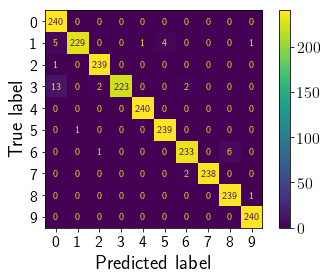

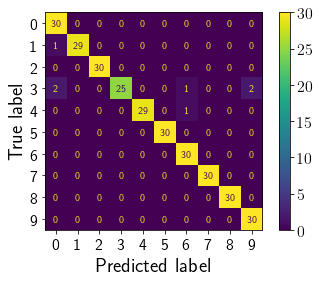

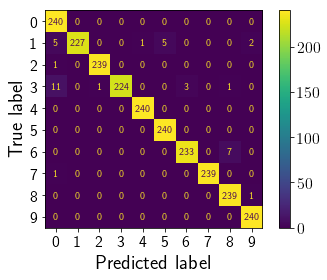

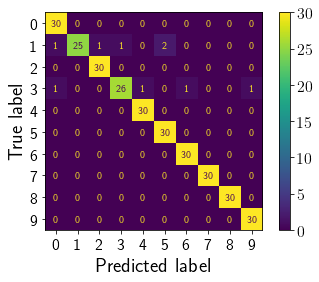

In [58]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn_rand.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn_rand, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn_rand.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn_rand, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))


Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn_kmeans.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn_kmeans, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn_kmeans.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn_kmeans, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of features from the training set

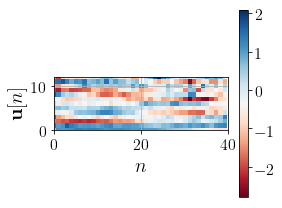

In [59]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_train_scaled[0].T,vmin=np.min(X_train_scaled[0]), vmax=np.max(X_train_scaled[0]))
plt.xlim([0,X_train_scaled[0].shape[0]])
plt.ylim([0, X_train_scaled[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_train.pdf', bbox_inches='tight', pad_inches=0.0)

Visualizations of features from the test set

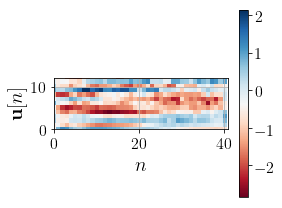

In [60]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_test_scaled[0].T,vmin=np.min(X_test_scaled[0]), vmax=np.max(X_test_scaled[0]))
plt.xlim([0, X_test[0].shape[0]])
plt.ylim([0, X_test[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_test.pdf', bbox_inches='tight', pad_inches=0.0)

Visualization of a reservoir state from the training set

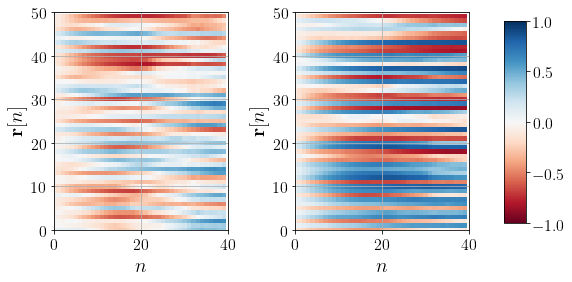

In [61]:
_ = esn_rand.predict(X=X_train_scaled[0], keep_reservoir_state=True)
_ = esn_kmeans.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn_rand.reservoir_state.shape[1], 50, replace=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
im = axes.flat[0].imshow(esn_rand.reservoir_state[:, index].T,vmin=-1, vmax=1)
axes.flat[0].set_xlim(0, esn_rand.reservoir_state.shape[0])
axes.flat[0].set_ylim(0, 50)
axes.flat[0].set_xlabel(r'$n$')
axes.flat[0].set_ylabel(r'$\mathbf{r}[n]$')
axes.flat[0].grid()
im = axes.flat[1].imshow(esn_kmeans.reservoir_state[:, index].T,vmin=-1, vmax=1)
axes.flat[1].set_xlim(0, esn_kmeans.reservoir_state.shape[0])
axes.flat[1].set_ylim(0, 50)
axes.flat[1].set_xlabel(r'$n$')
axes.flat[1].set_ylabel(r'$\mathbf{r}[n]$')
axes.flat[1].grid()

fig.subplots_adjust(right=1.15)
cbar_ax = fig.add_axes([1.2, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.savefig('k_res_train.pdf', bbox_inches='tight', pad_inches=0.0)

Visualization of a reservoir state from the test set

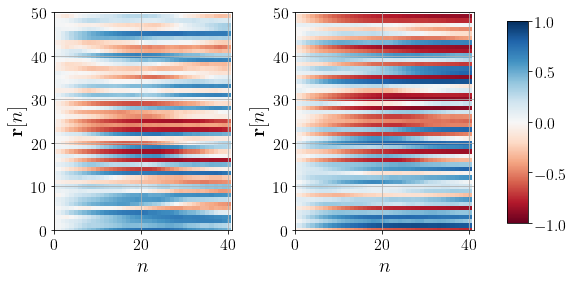

In [62]:
_ = esn_rand.predict(X=X_test_scaled[0], keep_reservoir_state=True)
_ = esn_kmeans.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn_rand.reservoir_state.shape[1], 50, replace=False)
fig, axes = plt.subplots(nrows=1, ncols=2)
im = axes.flat[0].imshow(esn_rand.reservoir_state[:, index].T,vmin=-1, vmax=1)
axes.flat[0].set_xlim(0, esn_rand.reservoir_state.shape[0])
axes.flat[0].set_ylim(0, 50)
axes.flat[0].set_xlabel(r'$n$')
axes.flat[0].set_ylabel(r'$\mathbf{r}[n]$')
axes.flat[0].grid()
im = axes.flat[1].imshow(esn_kmeans.reservoir_state[:, index].T,vmin=-1, vmax=1)
axes.flat[1].set_xlim(0, esn_kmeans.reservoir_state.shape[0])
axes.flat[1].set_ylim(0, 50)
axes.flat[1].set_xlabel(r'$n$')
axes.flat[1].set_ylabel(r'$\mathbf{r}[n]$')
axes.flat[1].grid()

fig.subplots_adjust(right=1.15)
cbar_ax = fig.add_axes([1.2, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.savefig('k_res_test.pdf', bbox_inches='tight', pad_inches=0.0)

Compute distance to labels

Visualization of a reservoir state from the training set

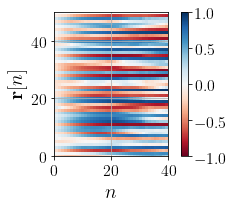

In [67]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_train.pdf', bbox_inches='tight', pad_inches=0.0)

Visualization of a reservoir state from the test set

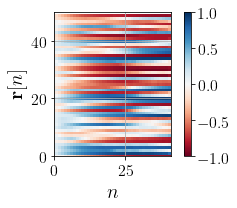

In [68]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_test.pdf', bbox_inches='tight', pad_inches=0.0)

In [45]:
new_train_features = [kmeans.transform(X) for X in X_train_scaled]
new_test_features = [kmeans.transform(X) for X in X_test_scaled]

Visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


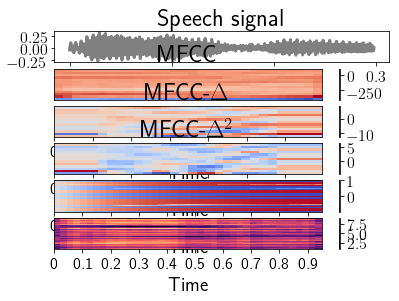

In [46]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(6, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(6, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(6, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(6, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(6, 1, 5)
_ = esn.predict(X=X_test[0], keep_reservoir_state=True)
librosa.display.specshow(esn.reservoir_state.T, x_axis='time')
plt.colorbar()
plt.subplot(6, 1, 6)
librosa.display.specshow(new_test_features[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()

Random experiments

In [10]:
for rs in range(20):
    base_esn = ESNRegressor(k_in=-1, input_scaling=0.4, spectral_radius=0.1, bias=0.0, leakage=0.1, reservoir_size=500,
                            k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                            bi_directional=False, solver='ridge', beta=1e-3, random_state=rs)
    print("Train the ESN model...")
    esn = clone(base_esn)
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
    esn.finalize()
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=0, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  0.9956521739 0.9541666667 0.9744680851       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  0.9913043478 0.9500000000 0.9702127660       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9876033058 0.9958333333 0.9917012448       240
           6  0.9914893617 0.9708333333 0.9810526316       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9876543210 1.0000000000 0.9937888199       240

    accuracy                      0.9858333333      2400
   macro avg  0.9862412952 0.9858333333 0.9858226684      2400


MSE test: 0.041275

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=4, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9957446809 0.9750000000 0.9852631579       240
           2  0.9917355372 1.0000000000 0.9958506224       240
           3  0.9955752212 0.9375000000 0.9656652361       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  0.9917355372 1.0000000000 0.9958506224       240
           6  0.9831932773 0.9750000000 0.9790794979       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9835390947 0.9958333333 0.9896480331       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9870833333      2400
   macro avg  0.9874383775 0.9870833333 0


MSE test: 0.041013

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=8, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  0.9957264957 0.9708333333 0.9831223629       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9291666667 0.9632829374       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9917012448 0.9958333333 0.9937629938       240
           6  0.9794238683 0.9916666667 0.9855072464       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9917355372 1.0000000000 0.9958506224       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9879166667      2400
   macro avg  0.9883639013 0.9879166667 0


MSE test: 0.040920

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=12, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9338521401 1.0000000000 0.9657947686       240
           1  0.9955947137 0.9416666667 0.9678800857       240
           2  0.9917355372 1.0000000000 0.9958506224       240
           3  1.0000000000 0.9291666667 0.9632829374       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9716599190 1.0000000000 0.9856262834       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  0.9916666667 0.9916666667 0.9916666667       240
           8  0.9756097561 1.0000000000 0.9876543210       240
           9  0.9917012448 0.9958333333 0.9937629938       240

    accuracy                      0.9829166667      2400
   macro avg  0.9834958736 0.9829166667 


MSE test: 0.041745

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=16, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  1.0000000000 0.9833333333 0.9915966387       240
           2  1.0000000000 0.9916666667 0.9958158996       240
           3  0.9955555556 0.9333333333 0.9634408602       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9917355372 1.0000000000 0.9958506224       240
           6  0.9832635983 0.9791666667 0.9812108559       240
           7  1.0000000000 0.9958333333 0.9979123173       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9879166667      2400
   macro avg  0.9883413510 0.9879166667 


MSE test: 0.041448



Random experiments

In [20]:
for rs in range(20):
    print("Train the ESN model...")
    kmeans = MiniBatchKMeans(n_clusters=500, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    base_esn = ESNRegressor(k_in=10, input_scaling=0.7, spectral_radius=0.7, bias=1.3, leakage=0.1, reservoir_size=500,
                            k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                            bi_directional=False, solver='ridge', beta=1e-3, random_state=rs)
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    esn = clone(base_esn)
    esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                                input_weights=w_in, reservoir_weights=None, bias_weights=None)
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
    esn.finalize()
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=0, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  1.0000000000 0.9916666667 0.9958158996       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795918367 1.0000000000 0.9896907216       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9895833333      2400
   macro avg  0.9899079006 0.9895833333 0.9895922135      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=1, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9583333333 0.9787234043       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9756097561 1.0000000000 0.9876543210       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9912500000      2400
   macro avg  0.9914545043 0.9912500000 0.9912381880      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=2, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9876543210 1.0000000000 0.9937888199       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9835390947 0.9958333333 0.9896480331       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9904166667      2400
   macro avg  0.9906269279 0.9904166667 0.9903991809      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=3, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9834024896 0.9875000000 0.9854469854       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9917012448 0.9958333333 0.9937629938       240
           9  0.9917012448 0.9958333333 0.9937629938       240

    accuracy                      0.9900000000      2400
   macro avg  0.9901911787 0.9900000000 0.9899895335      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=4, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9338521401 1.0000000000 0.9657947686       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9333333333 0.9655172414       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9887500000      2400
   macro avg  0.9892317759 0.9887500000 0.9887495504      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=5, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9638554217 1.0000000000 0.9815950920       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 1.0000000000 1.0000000000       240
           3  0.9956709957 0.9583333333 0.9766454352       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9790794979 0.9750000000 0.9770354906       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9794238683 0.9916666667 0.9855072464       240
           9  1.0000000000 1.0000000000 1.0000000000       240

    accuracy                      0.9904166667      2400
   macro avg  0.9905494916 0.9904166667 0.9904090502      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=6, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9957983193 0.9875000000 0.9916317992       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9915611814 0.9791666667 0.9853249476       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9895833333      2400
   macro avg  0.9899609785 0.9895833333 0.9895820471      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=7, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9715447154 0.9958333333 0.9835390947       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894984030 0.9891666667 0.9891522151      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=8, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  1.0000000000 0.9625000000 0.9808917197       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9908333333      2400
   macro avg  0.9910577135 0.9908333333 0.9908425745      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=9, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9957983193 0.9875000000 0.9916317992       240
           3  0.9913419913 0.9541666667 0.9723991507       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9874476987 0.9833333333 0.9853862213       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9908333333      2400
   macro avg  0.9910101585 0.9908333333 0.9908285281      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=10, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9917012448 0.9958333333 0.9937629938       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9755102041 0.9958333333 0.9855670103       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9883333333      2400
   macro avg  0.9886827237 0.9883333333 0.9883192710      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=11, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  0.9956521739 0.9541666667 0.9744680851       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9915966387 0.9833333333 0.9874476987       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9916666667      2400
   macro avg  0.9918389948 0.9916666667 0.9916550286      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=12, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9891666667      2400
   macro avg  0.9895418565 0.9891666667 0.9891907723      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=13, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9914529915 0.9666666667 0.9789029536       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894810019 0.9891666667 0.9891632457      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=14, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  0.9917012448 0.9958333333 0.9937629938       240
           3  1.0000000000 0.9500000000 0.9743589744       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9914893617 0.9708333333 0.9810526316       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795918367 1.0000000000 0.9896907216       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9895833333      2400
   macro avg  0.9898985204 0.9895833333 0.9895794365      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=15, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9904166667      2400
   macro avg  0.9906799792 0.9904166667 0.9904206734      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=16, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956521739 0.9541666667 0.9744680851       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9831223629 0.9708333333 0.9769392034       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894014164 0.9891666667 0.9891664431      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=17, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9500000000 0.9743589744       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9875000000 0.9875000000 0.9875000000       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9917355372 1.0000000000 0.9958506224       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9920833333      2400
   macro avg  0.9922945414 0.9920833333 0.9920709884      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=18, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  0.9913043478 0.9500000000 0.9702127660       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9874476987 0.9833333333 0.9853862213       240
           7  1.0000000000 0.9875000000 0.9937106918       240
           8  0.9876033058 0.9958333333 0.9917012448       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9900000000      2400
   macro avg  0.9902489098 0.9900000000 0.9900045338      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=19, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956140351 0.9458333333 0.9700854701       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9792531120 0.9833333333 0.9812889813       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876033058 0.9958333333 0.9917012448       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9900000000      2400
   macro avg  0.9902333827 0.9900000000 0.9899896254      2400
we

Increase the reservoir size

In [40]:
base_esn = ESNRegressor(k_in=10, input_scaling=1.2, spectral_radius=0.6, bias=0.7, leakage=0.1, reservoir_size=4000,
                        k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=1)
esn = clone(base_esn)
new_input_weights = kmeans.cluster_centers_
# To compute the norm of the cluster centers, use the following line:
w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, 3500), (0, 0)), mode='constant', constant_values=0)
print(w_in.shape)
esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                            input_weights=w_in, reservoir_weights=None, bias_weights=None)

(4000, 13)


In [41]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn.finalize()
print("done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [10:43<00:00,  3.99it/s]


done!


Test

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:40<00:00, 58.82it/s]


Classification training report for estimator ESNRegressor(beta=0.001, bias=0.7, input_scaling=1.2, k_in=10, k_res=5,
             leakage=0.1, random_state=1, reservoir_size=4000,
             spectral_radius=0.6):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9625000000 0.9808917197       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9957627119 0.9791666667 0.9873949580       240
           7  1.0000000000 0.9958333333 0.9979123173       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9933333333      2400
   macro avg  0.9935118278 0.9933333333 0.

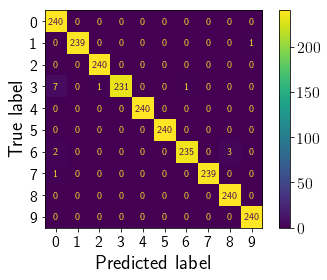

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.28it/s]


Classification test report for estimator ESNRegressor(beta=0.001, bias=0.7, input_scaling=1.2, k_in=10, k_res=5,
             leakage=0.1, random_state=1, reservoir_size=4000,
             spectral_radius=0.6):
              precision    recall  f1-score   support

           0  0.9677419355 1.0000000000 0.9836065574        30
           1  1.0000000000 1.0000000000 1.0000000000        30
           2  1.0000000000 1.0000000000 1.0000000000        30
           3  1.0000000000 0.9666666667 0.9830508475        30
           4  1.0000000000 1.0000000000 1.0000000000        30
           5  1.0000000000 1.0000000000 1.0000000000        30
           6  1.0000000000 1.0000000000 1.0000000000        30
           7  1.0000000000 1.0000000000 1.0000000000        30
           8  1.0000000000 1.0000000000 1.0000000000        30
           9  1.0000000000 1.0000000000 1.0000000000        30

    accuracy                      0.9966666667       300
   macro avg  0.9967741935 0.9966666667 0.9966

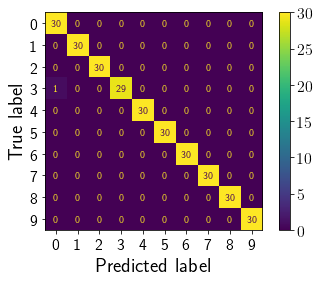

In [42]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of a reservoir state from the training set

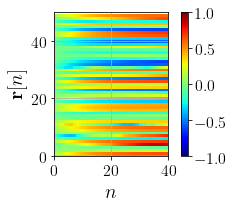

In [43]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_train.pdf')

Visualization of a reservoir state from the test set

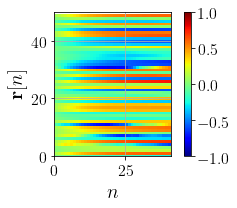

In [44]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_test.pdf')

Functions to fit KMeans and KMedoids for different settings (K, minibatch)

In [ ]:
def fit_k_means(k, mini_batch=False):
    if mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0, max_no_improvement=50, init_size=None, n_init=20, reassignment_ratio=0, random_state=0)
    else:
        kmeans = KMeans(n_clusters=k, max_iter=300, tol=0, random_state=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    return kmeans.inertia_

def fit_k_medoids(k):
    kmedoids = KMedoids(n_clusters=k, metric='euclidean',init='k-medoids++', max_iter=300, random_state=0)
    kmedoids.fit(X=np.vstack(X_train_scaled))
    return kmedoids.inertia_


Sweep along various $K$ and compare $K$-means, Mini-batch $K$-means and $K$-medoids

In [ ]:
# inertias_k_means = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_means)(k, False) for k in range(10, 1001, 10))
inertias_mini_batch_k_means = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_means)(k, True) for k in range(10, 1001, 10))
# inertias_k_medoids = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_medoids)(k) for k in range(10, 501, 10))

Visualization

In [ ]:
plt.figure(figsize=(6, 3))
# plt.plot(range(10, 1001, 10), inertias_k_means, label=r"$K$-Means")
plt.plot(range(10, 1001, 10), inertias_mini_batch_k_means, label=r"Mini-batch-$K$-Means")
# plt.plot(range(10, 501, 10), inertias_k_medoids, label="$K-\text{Medoids}$")
plt.xlabel(r'$K$')
plt.ylabel(r'$\mathrm{SSE}$')
plt.xlim([10, 1000])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("minibatch_elbow_curve.pdf")